In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float64')
train_images = (train_images-127.5)/127.5

In [4]:
buffer_size = 60000
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

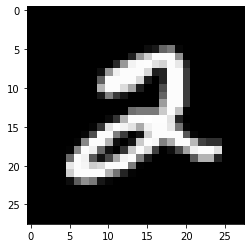

In [5]:
plt.imshow(train_images[5].reshape(28, 28), cmap = 'gray')

In [6]:
def make_generator_model():
  model = tf.keras.Sequential()

  model.add(layers.Dense(7*7*256, use_bias = False, input_shape = (100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  model.add(layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation = 'tanh'))

  return model

In [24]:
generator = make_generator_model()

In [8]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [9]:
def make_discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = [28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [23]:
discriminator = make_discriminator_model()

In [11]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [13]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [14]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

In [17]:
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)
    
    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [26]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

In [27]:
train(train_dataset, epochs)

In [28]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [29]:
pred_images = generator(seed, training = False)

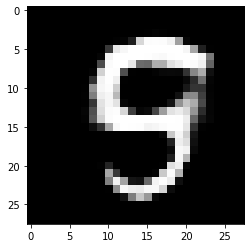

In [30]:
plt.imshow(np.array(pred_images[5]).reshape(28, 28), cmap = 'gray')

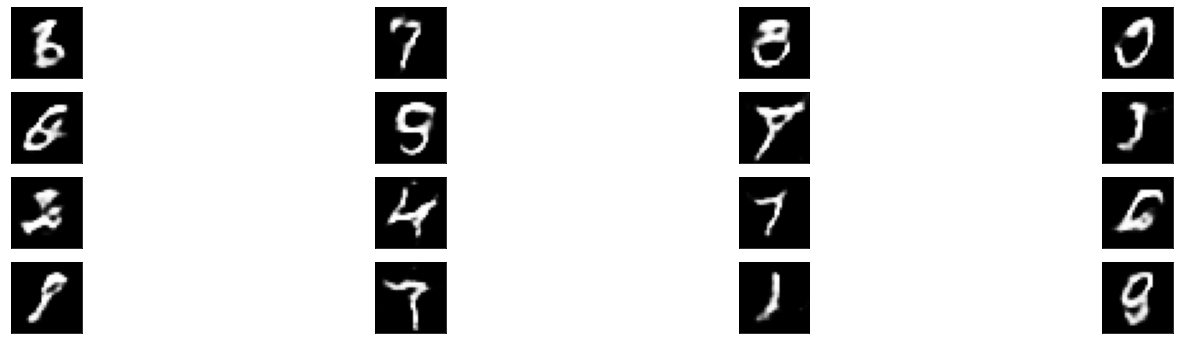

In [31]:
figure = plt.figure(figsize = (25, 6))

for i in range(0, 16):
  ax = figure.add_subplot(4, 4, i+1, xticks = [], yticks = [])
  plt.imshow(np.array(pred_images[i]).reshape(28, 28), cmap = 'gray')